In [10]:
# Install required libraries
!pip install lime shap scikit-learn numpy pandas matplotlib tensorflow pillow

# Note: After installation, restart the runtime to ensure all libraries are properly loaded.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c81f039287147433511456c56af050c0201bc98a0eaba41a95019d47ce9afd91
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import pandas as pd
import cv2
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split

In [2]:
import kagglehub
path = kagglehub.dataset_download("fernando2rad/x-ray-lung-diseases-images-9-classes")

# Preprocess images
def preprocess_images(source_folder, target_folder, img_size=(256, 256)):
    categories = os.listdir(source_folder)
    for category in categories:
        img_paths = os.listdir(os.path.join(source_folder, category))
        os.makedirs(os.path.join(target_folder, category), exist_ok=True)
        for img_name in tqdm(img_paths, desc=f"Processing {category}"):
            img_path = os.path.join(source_folder, category, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, img_size)
            cv2.imwrite(os.path.join(target_folder, category, img_name), img_resized)

source_dir = '/kaggle/input/x-ray-lung-diseases-images-9-classes'
target_dir = '/kaggle/processed/x-ray-lung-diseases-images'
preprocess_images(source_dir, target_dir)

Processing 04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia): 100%|██████████| 644/644 [00:05<00:00, 108.89it/s]
Processing 02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema): 100%|██████████| 678/678 [00:05<00:00, 129.99it/s]
Processing 03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio): 100%|██████████| 629/629 [00:05<00:00, 123.60it/s]
Processing 08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias): 100%|██████████| 544/544 [00:04<00:00, 125.24it/s]
Processing 06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases): 100%|██████████| 658/658 [00:05<00:00, 127.69it/s]
Processing 05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose): 100%|██████████| 594/594 [00:04<00:00, 123.73it/s]
Processing 00 Anatomia Normal: 100%|██████████| 1340/1340 [00:12<00:00, 111.27it/s]
Processing 07 Alterações de Mediastino (Pericardite, Malfo

In [3]:
# Split dataset
def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    classes = os.listdir(source_dir)
    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)
        train_val, test = train_test_split(images, test_size=1 - (train_ratio + val_ratio), random_state=42)
        train, val = train_test_split(train_val, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)
        for split_name, split_data in zip(['train', 'val', 'test'], [train, val, test]):
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for img in split_data:
                shutil.copy(os.path.join(class_path, img), os.path.join(split_class_dir, img))

processed_output = '/kaggle/working/xray_split'
split_dataset(target_dir, processed_output)

In [4]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

selected_classes = ['00 Anatomia Normal', '01 Processos Inflamatórios Pulmonares (Pneumonia)']

def load_generators(size):
    train_generator = train_datagen.flow_from_directory(
        os.path.join(processed_output, 'train'),
        target_size=size,
        color_mode='grayscale',
        classes=selected_classes,
        class_mode='binary',
        batch_size=32,
        shuffle=True
    )
    val_generator = val_test_datagen.flow_from_directory(
        os.path.join(processed_output, 'val'),
        target_size=size,
        color_mode='grayscale',
        classes=selected_classes,
        class_mode='binary',
        batch_size=32,
        shuffle=False
    )
    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(processed_output, 'test'),
        target_size=size,
        color_mode='grayscale',
        classes=selected_classes,
        class_mode='binary',
        batch_size=32,
        shuffle=False
    )
    return train_generator, val_generator, test_generator

In [5]:
# Build VGG-16 based model
def build_vgg16_binary(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [6]:
# Set resolution
img_size = (256, 256)
input_shape = (256, 256, 3)

# Load 3-channel grayscale data by repeating channel
train_gen, val_gen, test_gen = load_generators(img_size)

def convert_to_rgb(generator):
    for batch in generator:
        batch_x = np.repeat(batch[0], 3, axis=-1)
        yield batch_x, batch[1]


Found 1678 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 362 images belonging to 2 classes.


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 574ms/step - accuracy: 0.6241 - loss: 1.5315 - val_accuracy: 0.8972 - val_loss: 0.2656
Epoch 2/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 656ms/step - accuracy: 0.8629 - loss: 0.3305 - val_accuracy: 0.9417 - val_loss: 0.1936
Epoch 3/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 389ms/step - accuracy: 0.8769 - loss: 0.2948 - val_accuracy: 0.9222 - val_loss: 0.1639
Epoch 4/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.8947 - loss: 0.2562 - val_accuracy: 0.9222 - val_loss: 0.1767
Epoch 5/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.8938 - loss: 0.2396 - val_accuracy: 0.8722 - val_loss: 0.2524
Epoch 6/6
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.8625 - loss: 0.2504 - val_accuracy: 0.9417 - val_loss: 0.1393
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step


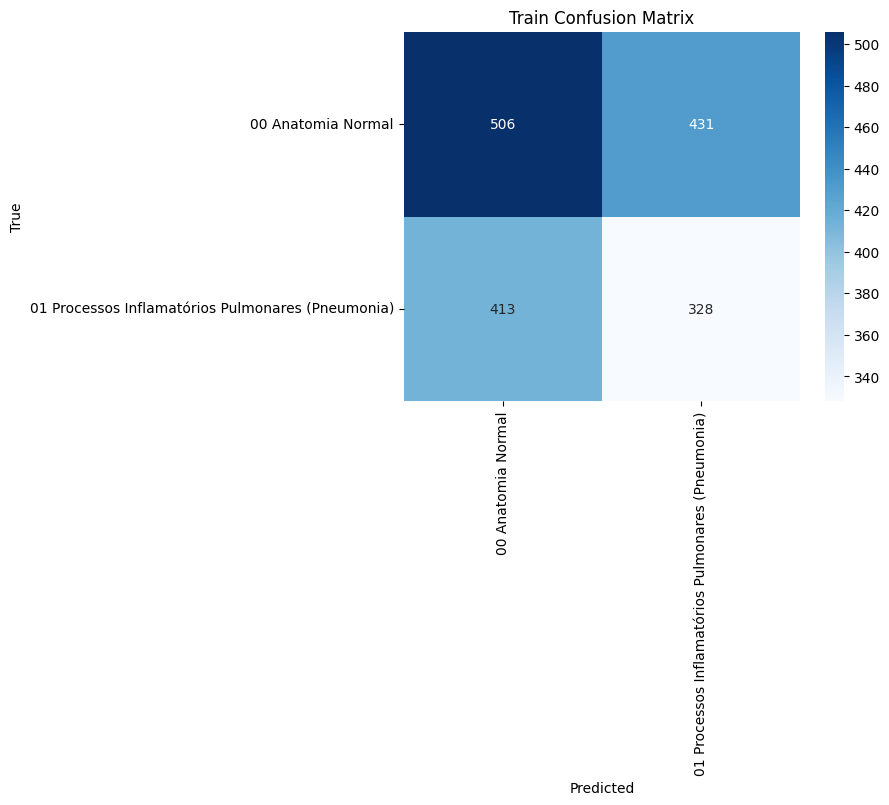

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 881ms/step


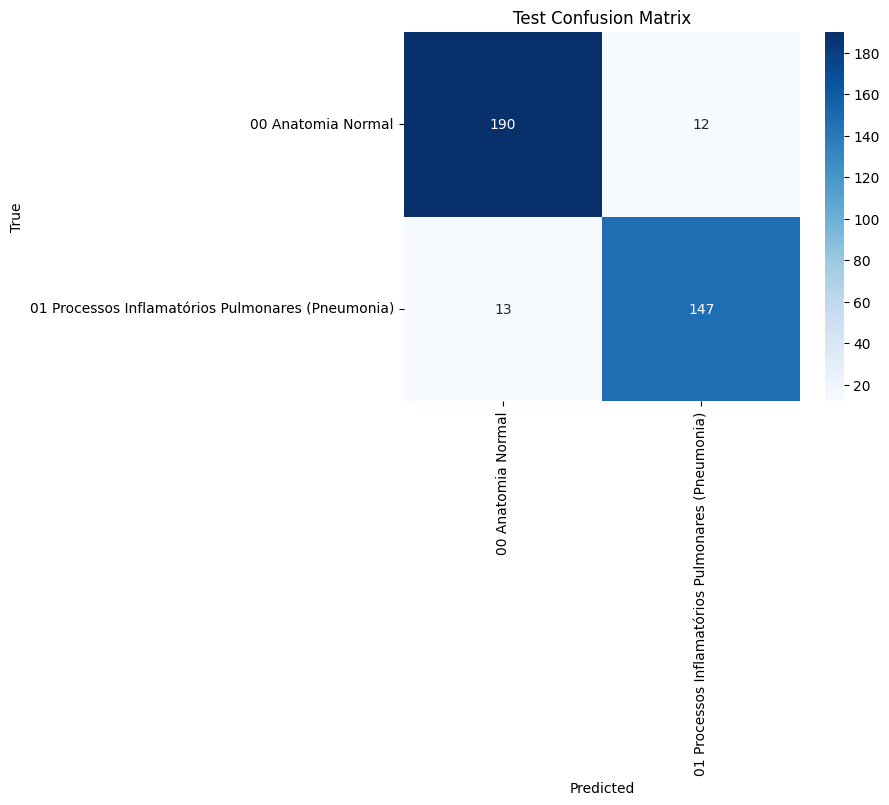

   Width  Height  Data size   TP   TN   FP   FN    Acc (%)
0    256     256       1678  328  506  431  413  49.702026
1    256     256        362  147  190   12   13  93.093923


In [7]:
# Define output shapes for the generator
output_shapes = ((None, 256, 256, 3), (None,))  # (image shape, label shape)

train_rgb = tf.data.Dataset.from_generator(
    lambda: convert_to_rgb(train_gen),
    output_types=(tf.float32, tf.float32),
    output_shapes=output_shapes  # Specify output shapes here
)
val_rgb = tf.data.Dataset.from_generator(
    lambda: convert_to_rgb(val_gen),
    output_types=(tf.float32, tf.float32),
    output_shapes=output_shapes  # Specify output shapes here
)
test_rgb = tf.data.Dataset.from_generator(
    lambda: convert_to_rgb(test_gen),
    output_types=(tf.float32, tf.float32),
    output_shapes=output_shapes  # Specify output shapes here
)
model = build_vgg16_binary(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_rgb,
    validation_data=val_rgb,
    epochs=6,
    callbacks=[early_stop],
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen)
)

model.save('/kaggle/working/my_trained_model.keras')

# Evaluation
def evaluate_and_plot(model, generator, dataset_name):
    y_true = generator.classes
    # Convert generator output to RGB before prediction
    y_pred = model.predict(convert_to_rgb(generator), verbose=1, steps=len(generator))
    y_pred = np.round(y_pred).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=generator.class_indices.keys(), yticklabels=generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    TP, TN = cm[1,1], cm[0,0]
    FP, FN = cm[0,1], cm[1,0]
    acc = (TP + TN) / np.sum(cm) * 100
    return TP, TN, FP, FN, acc

TP_train, TN_train, FP_train, FN_train, acc_train = evaluate_and_plot(model, train_gen, 'Train')
TP_test, TN_test, FP_test, FN_test, acc_test = evaluate_and_plot(model, test_gen, 'Test')

# Save results
results = [
    [256, 256, len(train_gen.classes), TP_train, TN_train, FP_train, FN_train, acc_train],
    [256, 256, len(test_gen.classes), TP_test, TN_test, FP_test, FN_test, acc_test]
]
columns = ['Width', 'Height', 'Data size', 'TP', 'TN', 'FP', 'FN', 'Acc (%)']
results_df = pd.DataFrame(results, columns=columns)
print(results_df)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/ste

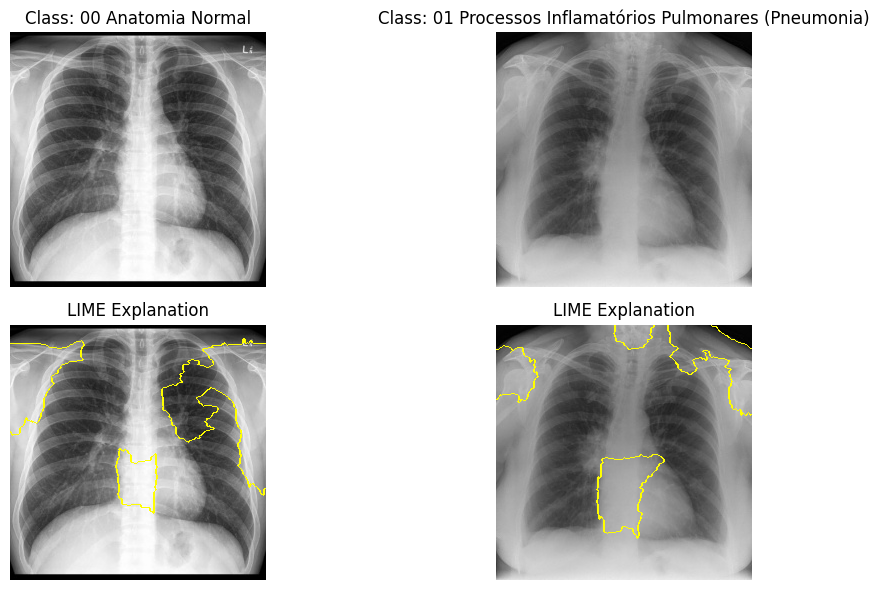

In [13]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# LIME explainer
explainer = lime_image.LimeImageExplainer()

# Wrapper to match model input
def model_predict(images):
    # Ensure images are RGB
    if images.shape[-1] == 3:
        images = images.astype('float32') / 255.0
    return model.predict(images)

# Pick one example from each class
# Pick one image per class
def get_one_image_per_class(generator):
    class_indices = generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    found_classes = set()
    examples = {}

    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        for j in range(len(y_batch)):
            label = int(y_batch[j])
            if label not in found_classes:
                image_gray = x_batch[j] * 255.0
                image_rgb = np.stack([image_gray] * 3, axis=-1).astype('uint8')
                examples[inv_class_indices[label]] = image_rgb
                found_classes.add(label)
            if len(found_classes) == len(class_indices):
                return examples
    return examples

examples = get_one_image_per_class(test_gen)

# Run LIME on examples
plt.figure(figsize=(12, 6))
for i, (label, image) in enumerate(examples.items()):
    # Reshape image to (height, width, 3) - ensure it's 3-channel RGB
    image = image.squeeze()  # Remove the extra dimension if present
    if image.ndim == 2:  # If grayscale, convert to RGB by repeating channels
        image = np.stack([image] * 3, axis=-1)

    explanation = explainer.explain_instance(
        image,
        model_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )


    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # Plot
    plt.subplot(2, len(examples), i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Class: {label}')
    plt.axis('off')

    plt.subplot(2, len(examples), i + 1 + len(examples))
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('LIME Explanation')
    plt.axis('off')

plt.tight_layout()
plt.show()
